# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

>1. The Kullback-Leibler divergence;
>2. The Wasserstein distance.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

>1. Metrics that compare density, such as KL divergence, can be computationally expensive, especially if the distributions are high-dimensional. Metrics that compare samples, such as Wasserstein distance, can suffer from high variance and may require large sample sizes to achieve reliable estimates.
>
>2. Metrics that compare density are more sensitive to outliers than metrics that compare samples.
>
>3. Metrics that compare density can provide insight into the differences between the distributions at a global level, while metrics that compare samples can provide insight into the differences at a local level.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

>* Increasing the value of N can plausibly result in a more heterogeneous collection of output samples, given that the noise vector affords the generator greater leeway to traverse. Nonetheless, a larger N has the potential to magnify the computational intricacy of both the generator and discriminator, alongside complicating the GAN's training process.
>
>* If N is diminished, the training can become more stable and effective, given that the generator has fewer parameters to learn, and the discriminator has fewer inputs to scrutinize. Alas, a smaller N could constrain the range of diversity in the generated samples, as the generator is afforded fewer degrees of freedom to traverse.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> One caveat of using the JSD as a training objective for the generator is that it is not a smooth function, which can make optimization difficult. Specifically, the JSD has a non-zero gradient everywhere, but the gradient can be unbounded when the distributions being compared have disjoint support. This can lead to unstable training, where the generator oscillates between generating samples that are too similar or too dissimilar to the real data.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> This generator loss does not privide feedback on the entire distribution $p_θ$. The generator might produce samples that are very similar to the real data, but not explore the entire distribution or produce diverse samples. The generator may be overfitting to the training set and not learning to generate new and varied data.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [17]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

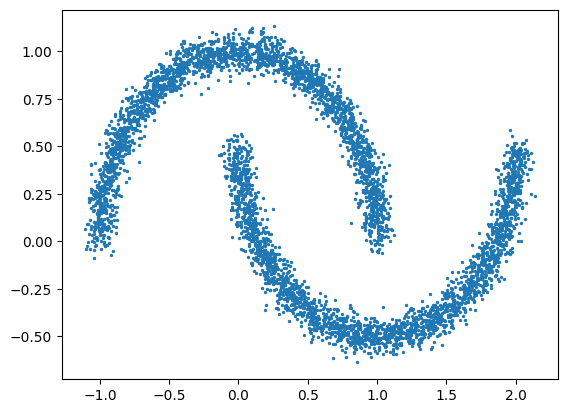

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [19]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 20000: discriminator: 1.386e+00, generator: 6.932e-01


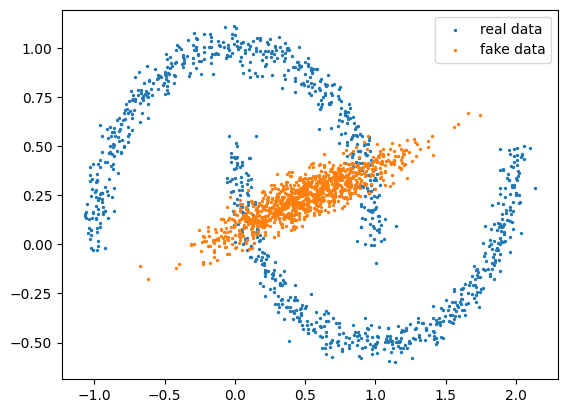

In [ ]:
from IPython.core.display import clear_output
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        disc_loss = -torch.mean(torch.log(torch.sigmoid(discriminator(real_batch))) + torch.log(1 - torch.sigmoid(discriminator(fake_batch))))
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    gen_loss = -torch.mean(torch.log(torch.sigmoid(discriminator(fake_batch))))
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()
        clear_output(wait=True)

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> If $D(x)$ is close to 1 for all real data x and close to 0 for all fake data x, the gradient of the generator loss with respect to the generator's parameters would be close to zero, which would result in very small updates to the generator's parameters during training. This could cause the generator to generate samples that are all very similar, and fail to capture the diversity of the real data.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 2)
        
    def __call__(self, z):
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [ ]:
from IPython.core.display import clear_output
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 2001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        disc_loss = -torch.mean(torch.log(torch.sigmoid(discriminator(real_batch))) + torch.log(1 - torch.sigmoid(discriminator(fake_batch))))
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    gen_loss = -torch.mean(torch.log(torch.sigmoid(discriminator(fake_batch))))
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()
        clear_output(wait=True)

step 2000: discriminator: 1.387e+00, generator: 6.893e-01


> * Increasing the depth and span of the generator lattice can expand the capability of the model and enhance its capacity to produce pragmatic exemplars. Nevertheless, amplifying the depth and span excessively may lead to overfitting and generate samples that look like the training data excessively.
>
>* Broadening the depth and width of the discriminator lattice can make it more challenging for the generator to delude the discriminator and help generate more samples. However, intensifying the depth and span excessively may cause the training of the discriminator to become unstable, and cause a reduction in the variety of generated outputs, known as mode collapse.
>
>* Increasing the value of TRAIN_RATIO or the frequency at which the discriminator is trained before the generator update can stabilize the training process and deter mode collapse. However, raising the TRAIN_RATIO value may decelerate the training process and cause the generator to converge more sluggishly.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> One can rewrite the KL divergence:
$$
D_{KL}(p_D | p_\theta) = \mathbb{E}{p_D} [\log p_D(x)] - \mathbb{E}{p_D}[\log p_\theta(x) ].
$$
>
>The term $\mathbb{E}_{p_D}\left[ \log p_D(x) \right]$ is a constant with respect to $\theta$, since it only depends on the data distribution $p_D$. Therefore,
$$
\operatorname{argmin}_\theta D_{KL}(p_D | p_\theta) = \operatorname{argmax}_\theta \mathbb{E}{p_D} [\log p_\theta(x)].
$$
>
>Thus, maximizing $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$ is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

vae-gaussian.png

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> The fact that $p(z)$ is never sampled during the training process might lead to a mismatch between the prior distribution and the distribution of $z$ generated by the probabilistic encoder $q_\phi(z|x)$. This mismatch can impact the ability of the VAE to generate diverse and plausible samples from the learned distribution $p_\theta(x)$.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> Assuming $p(z)$ is a standard Gaussian distribution $\mathcal{N}(0, I_d)$, and $q_\phi(z|x)$ is a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x), \text{Diag}(\sigma_\phi^2(x)))$, the KL-divergence between the two distributions reads:
$$
D_{KL}(q_\phi(z | x) \| p(z)) = \frac{1}{2} \left( \sum_{i=1}^d (\sigma_\phi^2(x)_i + \mu_\phi^2(x)_i - \log \sigma_\phi^2(x)_i) - d \right).
$$

In [22]:
def kl_loss(mu, logvar):
    return 0.5 * torch.sum(logvar.exp() + mu**2 - logvar-1)

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> The negative log likelihood $-\log p_\theta(x | z)$ reads:
$$
-\log p_\theta(x | z) = \frac{1}{2} \sum_{i=1}^d \left[ \log(2\pi\sigma_\theta^2(z)_i) + \frac{(x_i - \mu_\theta(z)_i)^2}{\sigma_\theta^2(z)_i} \right].
$$


In [23]:
def neg_log_likelihood(x, mu, logvar):
    return 0.5 * torch.sum(np.log(2 * np.pi) + logvar + ((x - mu)**2 / torch.exp(logvar)))

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [30]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 3.840e+02, rec: 5.069e+02


step 1000: KL: 1.531e+01, rec: 2.387e+02


step 2000: KL: 4.979e+01, rec: 1.854e+02


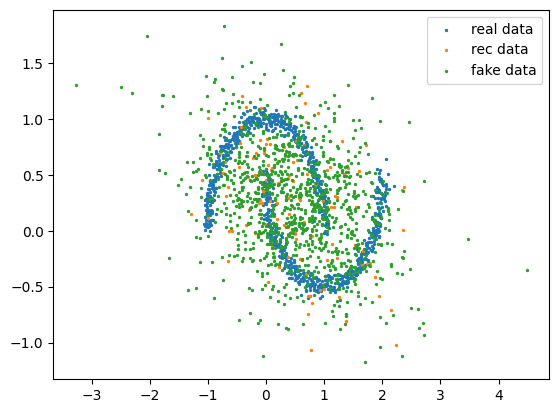

step 3000: KL: 5.963e+01, rec: 1.816e+02


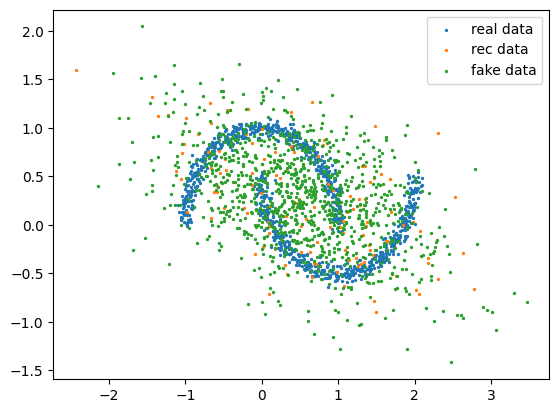

step 4000: KL: 6.150e+01, rec: 1.710e+02


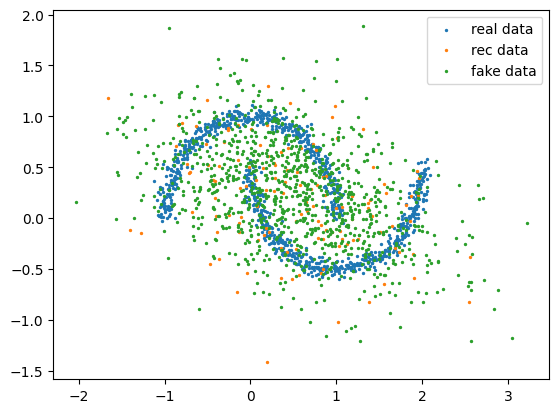

step 5000: KL: 6.379e+01, rec: 1.714e+02


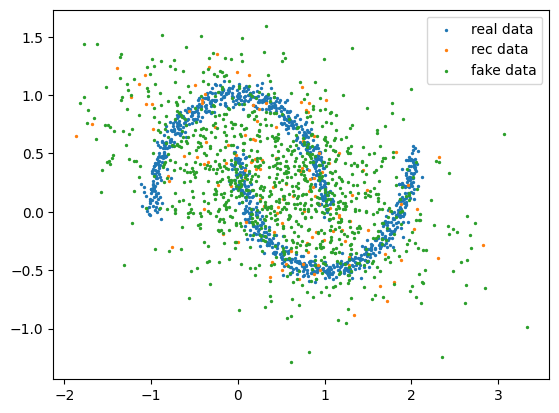

step 6000: KL: 6.364e+01, rec: 1.712e+02


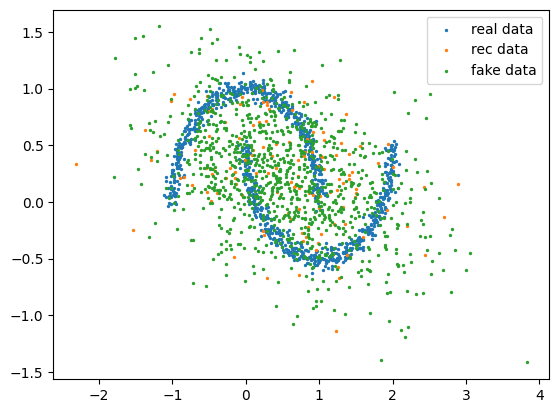

step 7000: KL: 6.415e+01, rec: 1.738e+02


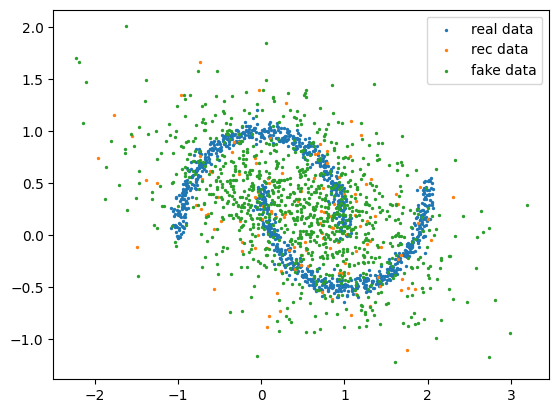

step 8000: KL: 6.467e+01, rec: 1.876e+02


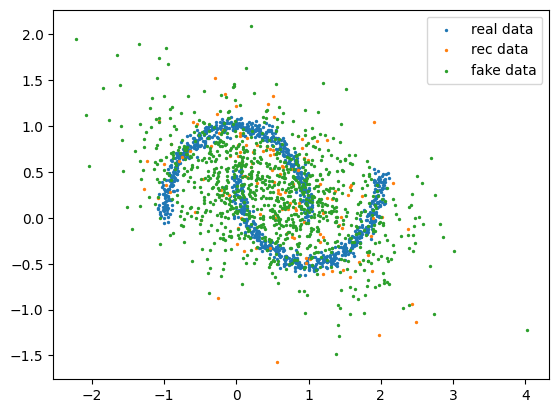

step 9000: KL: 6.501e+01, rec: 1.802e+02


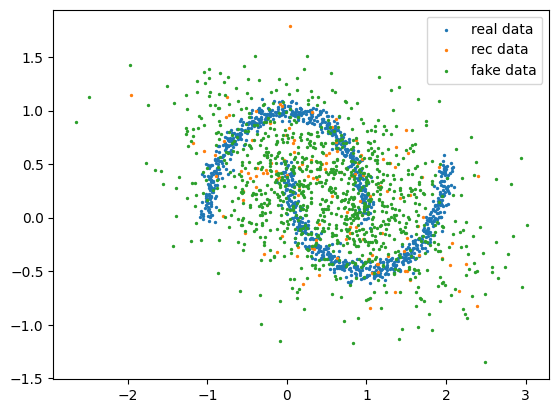

step 10000: KL: 6.288e+01, rec: 1.743e+02


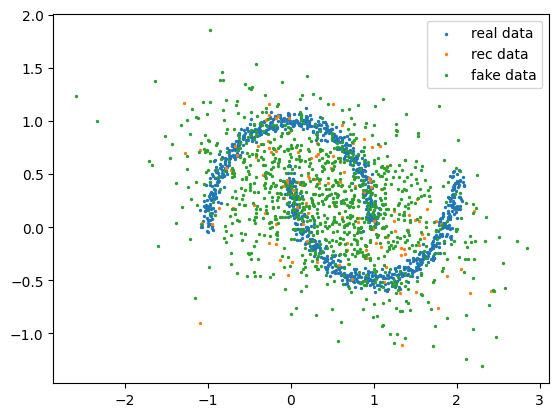

In [31]:
# Total number of training iterations for the VAE
N_ITER = 10001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = kl_loss(enc_mu,enc_logvar)
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    std = torch.exp(0.5 * enc_logvar)
    eps = torch.randn_like(std)
    z = enc_mu + eps * std
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = neg_log_likelihood(x, dec_mu, dec_logvar)
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

> In the following code, we added one hidden layer.

step 0: KL: 2.648e+01, rec: 6.287e+02


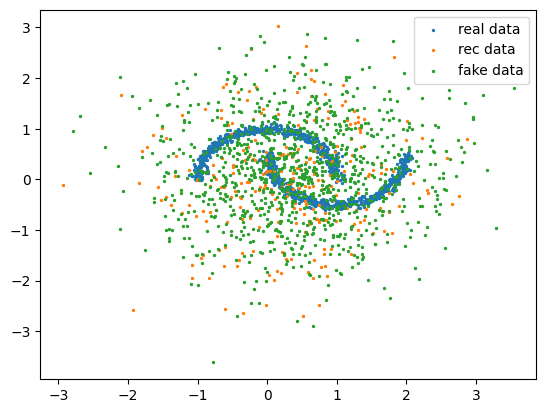

step 1000: KL: 1.122e+03, rec: -7.817e+02


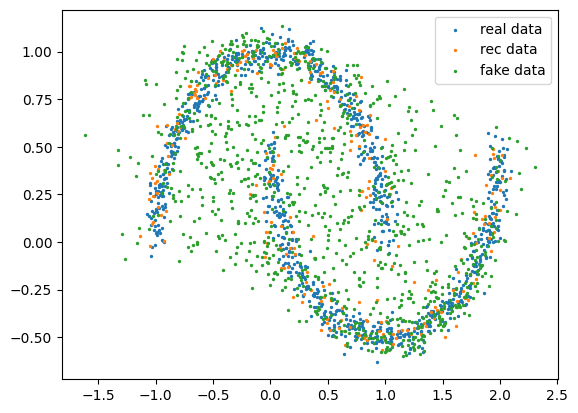

step 2000: KL: 1.138e+03, rec: -7.848e+02


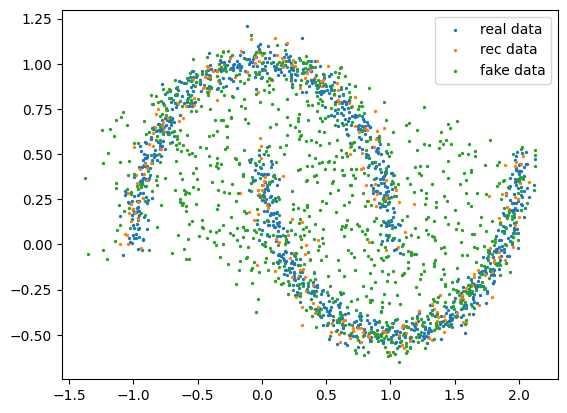

step 3000: KL: 1.143e+03, rec: -8.063e+02


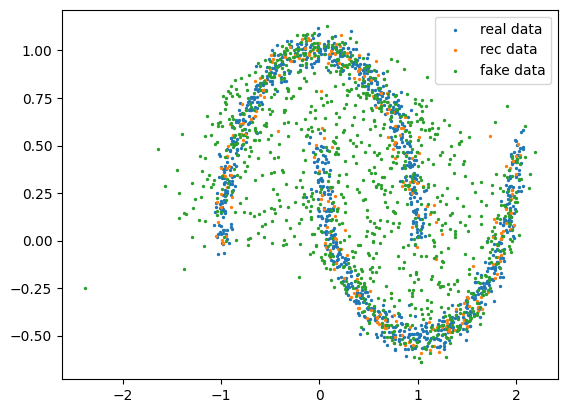

step 4000: KL: 1.148e+03, rec: -8.031e+02


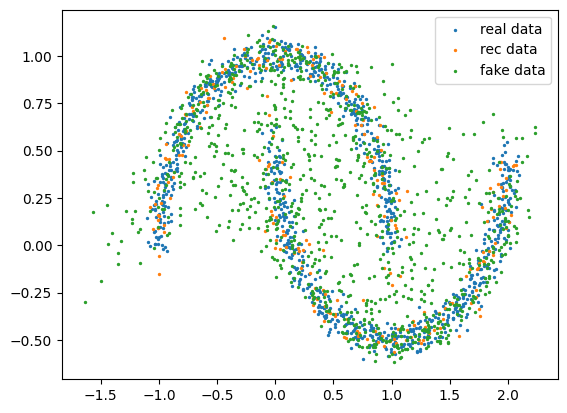

step 5000: KL: 1.121e+03, rec: -8.780e+02


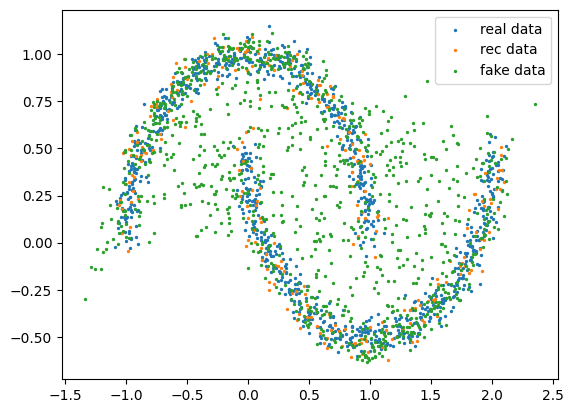

step 6000: KL: 1.123e+03, rec: -8.176e+02


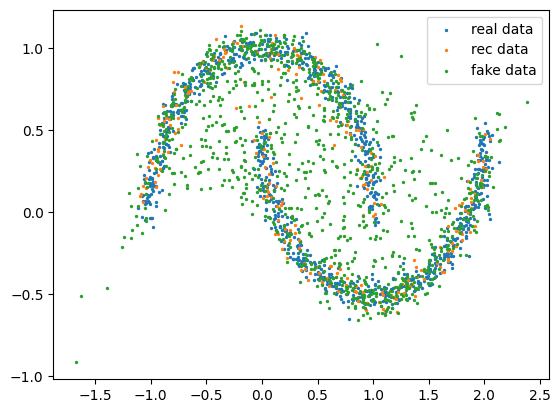

step 7000: KL: 1.128e+03, rec: -8.291e+02


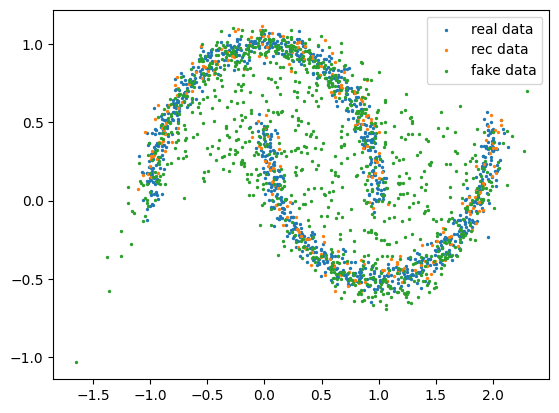

step 8000: KL: 1.120e+03, rec: -7.641e+02


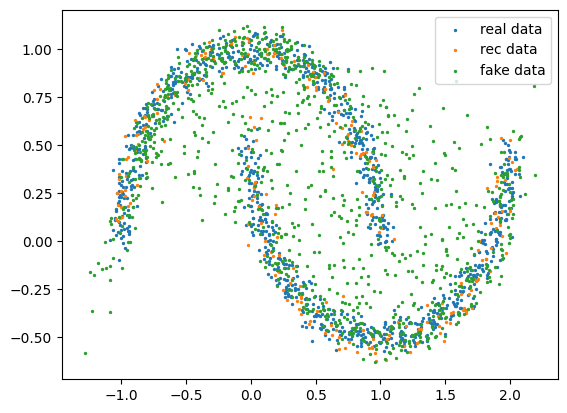

step 9000: KL: 1.136e+03, rec: -8.640e+02


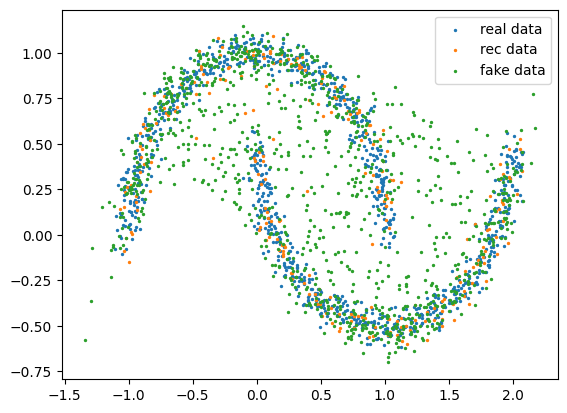

step 10000: KL: 1.146e+03, rec: -8.743e+02


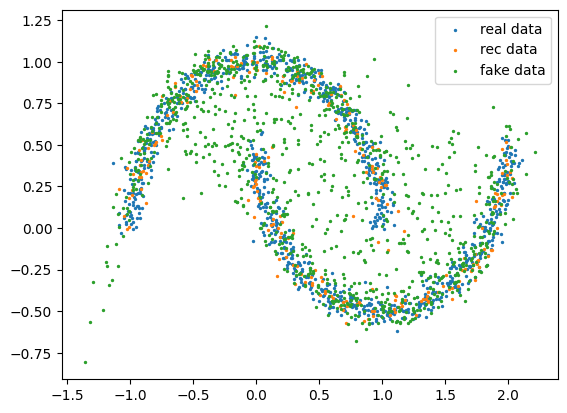

In [32]:
LATENT_N = 2

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, LATENT_N)
        self.fc_logvar = nn.Linear(128, LATENT_N)

    def __call__(self, x):
        x = torch.relu(self.fc1(x))
        mu = self.fc2(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 128)
        self.fc_mu = nn.Linear(128, 2)
        self.fc_logvar = nn.Linear(128, 2)

    def __call__(self, z):
        z = torch.relu(self.fc1(z))
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5 * logvar))


N_ITER = 10001
BATCHLEN = 258
# beta = 0.8

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5, 0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5, 0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)
    enc_mu, enc_logvar = encoder(x)
    loss_kl = kl_loss(enc_mu, enc_logvar)

    std = torch.exp(0.5 * enc_logvar)
    eps = torch.randn_like(std)
    z = enc_mu + eps * std

    dec_mu, dec_logvar = decoder(z)
    loss_rec = neg_log_likelihood(x, dec_mu, dec_logvar)
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i % 1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5 * dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

step 0: KL: 2.703e+01, rec: 7.674e+05


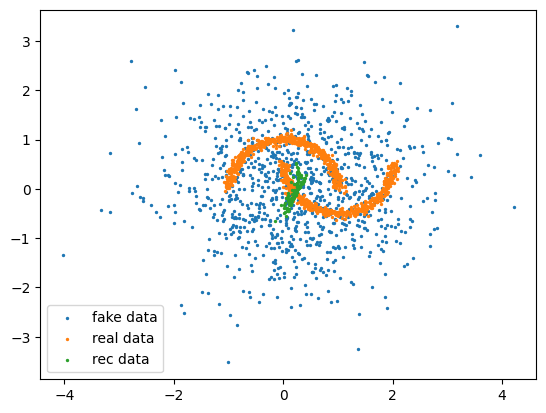

step 1000: KL: 1.262e+03, rec: -4.068e+02


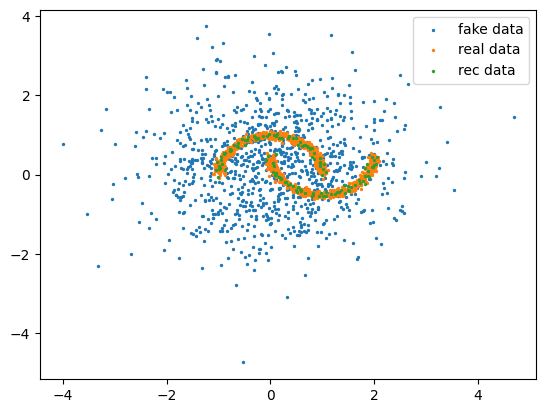

step 2000: KL: 1.245e+03, rec: -7.435e+02


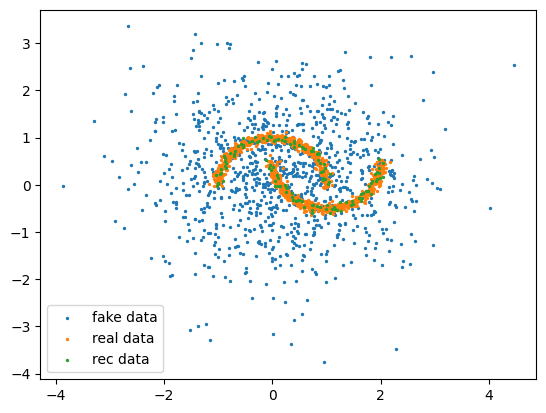

step 3000: KL: 1.179e+03, rec: -7.708e+02


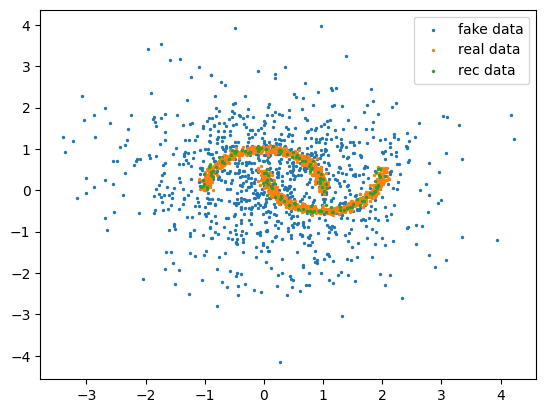

step 4000: KL: 1.148e+03, rec: -7.731e+02


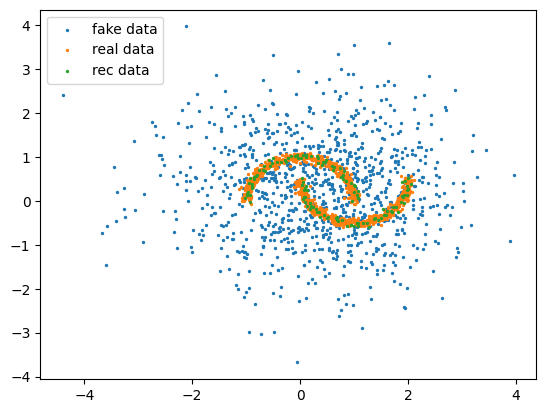

step 5000: KL: 1.120e+03, rec: -8.070e+02


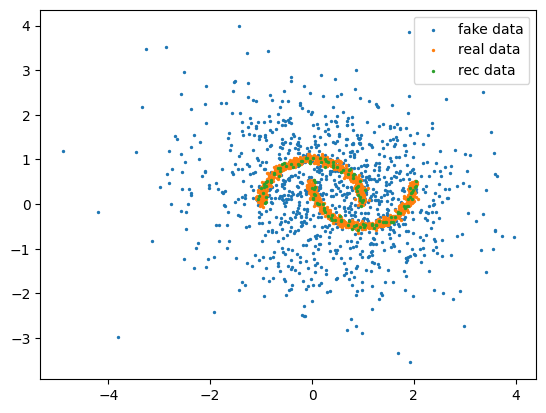

step 6000: KL: 1.107e+03, rec: -8.042e+02


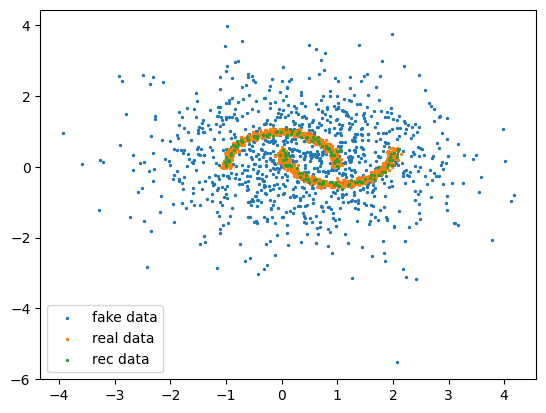

step 7000: KL: 1.101e+03, rec: -8.262e+02


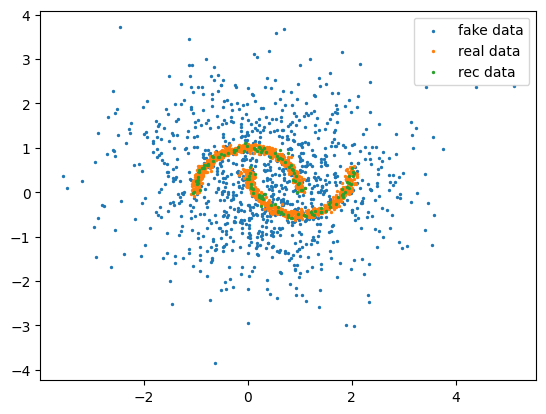

step 8000: KL: 1.098e+03, rec: -8.061e+02


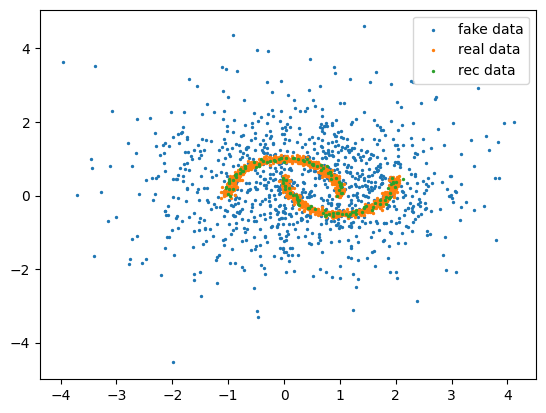

step 9000: KL: 1.089e+03, rec: -8.283e+02


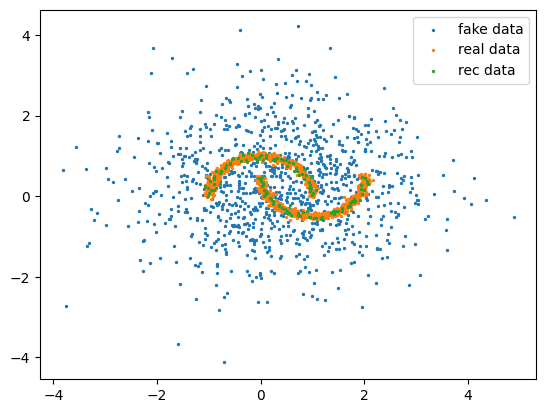

step 10000: KL: 1.082e+03, rec: -8.212e+02


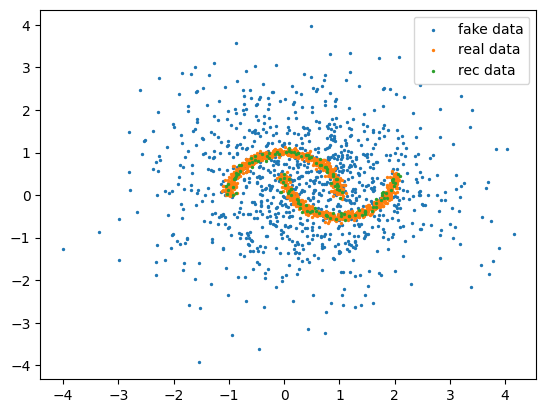

In [33]:
N_ITER = 10001
BATCHLEN = 128
# beta = 0.8

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.9, 0.999))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    
    # Compute the KL part of the loss
    loss_kl = kl_loss(enc_mu,enc_logvar)
    
    # Sample z from q(z|x)
    std = torch.exp(0.5 * enc_logvar)
    eps = torch.randn_like(std)
    z = enc_mu + eps * std
    
    dec_mu, _ = decoder(z)
    
    # Compute the reconstruction part of the loss
    fixed_var = 1e-4
    loss_rec = 0.5 * torch.sum((x - dec_mu).pow(2) / fixed_var + np.log(2 * np.pi * fixed_var))
    
    (loss_kl*beta + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i % 1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = dec_mu.detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(fake_batch[:, 0], fake_batch[:, 1], s=2.0, label='fake data')
        plt.scatter(real_batch[:, 0], real_batch[:, 1], s=2.0, label='real data')
        plt.scatter(rec_batch[:, 0], rec_batch[:, 1], s=2.0, label='rec data')
        plt.legend()
        plt.show()

>* The VAE generates samples close to the mean, resulting in better reconstruction quality for data points in close proximity to the true mean of the data distribution. However, it may face difficulty reconstructing data points that deviate significantly from the mean due to inadequate variance capturing.
>
>* Fixing the value of $\sigma_\theta(z)$ in VAE algorithm limits its capacity to model the data distribution, leading to a poor fit to the actual data distribution, especially when dealing with a highly complex structure or greater variance.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

>* A weak encoder may inadequately encapsulate the data structure in the latent space, leading to suboptimal approximations of the true posterior distribution pθ(z|x). This, in turn, would culminate in improper use of the latent space, and possibly escalate the KL-divergence component in the loss function. The outcome would be the VAE's inability to accurately reconstruct input data.
>
>* On the other hand, a feeble decoder may not generate samples that accurately resemble the true data distribution. The VAE would struggle to reconstruct the input data from the latent space, leading to a higher reconstruction loss. This outcome would produce inferior-quality generated samples that inadequately represent the true data distribution.
>
>* Conversely, a powerful encoder could more accurately approximate the true posterior distribution pθ(z|x). This would facilitate more efficient use of the latent space, reducing the KL-divergence component in the loss function. However, if the encoder were too potent, it could overfit the training data, limiting its ability to generalize to unseen data.
>
>* Similarly, a potent decoder would be capable of generating samples that closely match the true data distribution, resulting in lower reconstruction loss and superior quality generated samples. However, an overly powerful decoder would be more susceptible to overfitting, consequently causing poor generalization to unseen data.

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> The change of variables formula for probability densities states that:
$$p_X(x) = p_Z(f(x)) \left|\det J_f(x)\right|,$$
>where $J_f(x) = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.
>
>Taking the logarithm, one gets:
$$\log(p_X(x))=\log(p_Z(f(x)))+\log \det J_f(x).$$
>Since $z = f(x)$, one can rewrite the equation as:
$$\log(p_X(x))=\log(p_Z(z))+\log \det J_f.$$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> $L(f) = -\mathbb{E}_{x \sim p_D} [\log \det J_f]$.


A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d}))$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
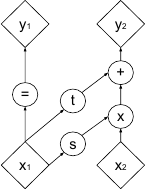

**Q16: Show that the defined mapping is indeed invertible**

> We want to find the inverse mapping for this forward pass, i.e., a function that computes $x$ given $y$.
>
> From the first equation, we can directly compute $x_{1:d}$ as $x_{1:d} = y_{1:d}$.
To find the inverse of the second equation, we first isolate $x_{d+1:D}$:
>
> $$x_{d+1:D} = (y_{d+1:D} - t(x_{1:d})) \odot \exp(-s(x_{1:d})).$$
>
> Both $x_{1:d}$ and $x_{d+1:D}$, which shows that the mapping is indeed invertible.

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> One has:
  $$\frac{\partial y}{\partial x_{d+1:D}}=\begin{bmatrix}
  \operatorname{diag}\left(\exp(s(x_{1:d}))\right) & \operatorname{diag}(t'(x_{1:d}))\\ 
  0_{(D-d)\times d}& I_{D-d}
  \end{bmatrix},$$
>
> where $\operatorname{diag}(v)$ denotes the diagonal matrix with vector $v$ on the diagonal, and $t'(x_{1:d})$ is the Jacobian matrix of $t$ with respect to $x_{1:d}$.
>
> The determinant of the Jacobian matrix is then given by:
>
> \begin{align*}
  \det J_f(x)&=\det\left(\frac{\partial y}{\partial x_{d+1:D}}\right)\\
  &=\det(\operatorname{diag}(\exp(s(x_{1:d}))\\
  &=\exp\left(\sum_j s(x_{1:d})_j\right).
  \end{align*}

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        out = self.relu(self.fc1(x_m))
        out = self.tanh(self.fc2(out))
        return out
        
    def tfun(self, x_m):
        out = self.relu(self.fc1(x_m))
        return self.fc2(out)
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m)
        t_out = self.tfun(y_m)
        x = y_m + (1 - self.mask) * ((y - t_out) * torch.exp(-s_out))
        return x


In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 20
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 512
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 16

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.020586
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.110931
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.113512
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.112469
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.115244
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.115823
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.116749
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.111215
====> Epoch: 1 Average train loss: -0.1109


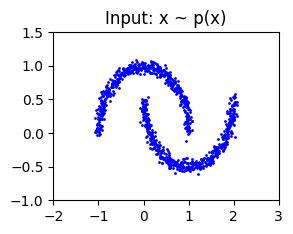

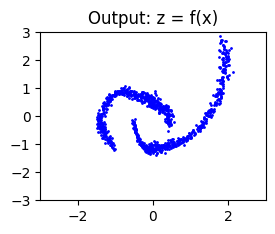

====> Test loss: -0.1112


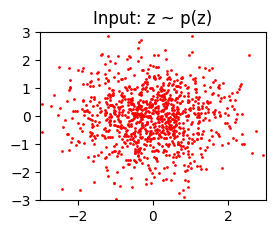

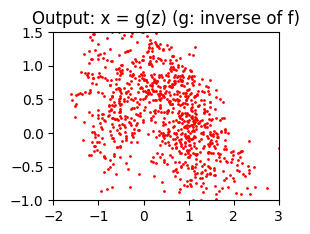

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.108191
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.112149
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.113224
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.113665
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.115616
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.116792
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.115664
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.117661
====> Epoch: 2 Average train loss: -0.1146


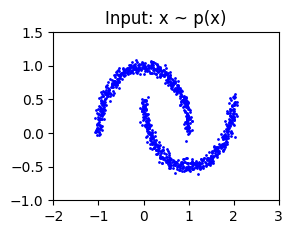

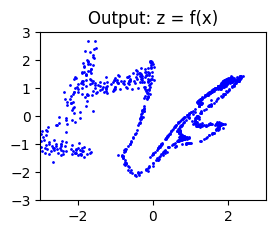

====> Test loss: -0.0993


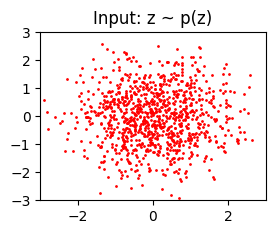

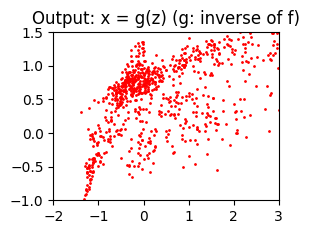

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.102188
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.113584
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.115014
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.112569
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.117744
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.118202
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.117044
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.119164
====> Epoch: 3 Average train loss: -0.1162


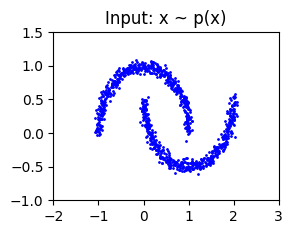

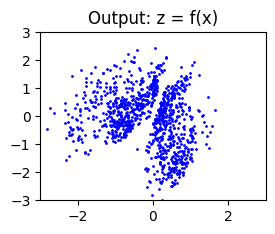

====> Test loss: -0.1220


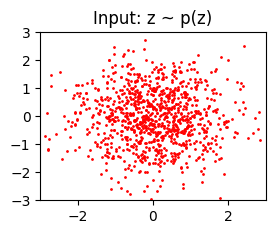

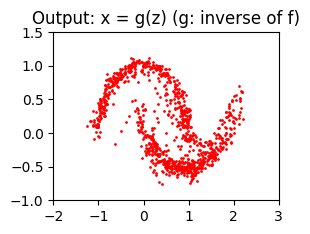

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.118667
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.119808
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.119741
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.116701
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.119417
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.120073
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.116725
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.119921
====> Epoch: 4 Average train loss: -0.1190


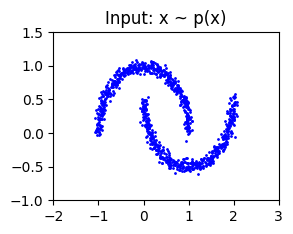

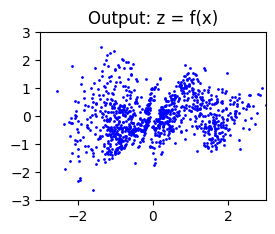

====> Test loss: -0.1225


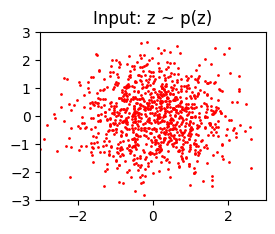

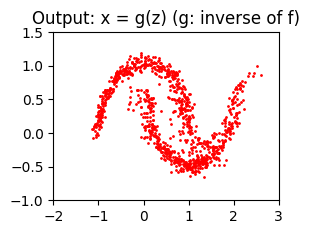

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.119590
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.119922
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.115312
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.119928
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.118867
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.117650
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.118289
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.120693
====> Epoch: 5 Average train loss: -0.1198


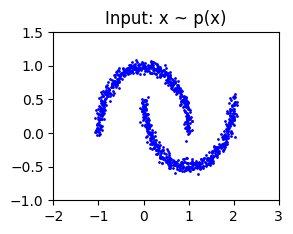

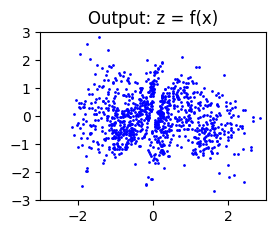

====> Test loss: -0.1237


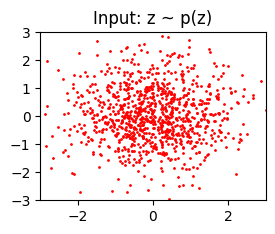

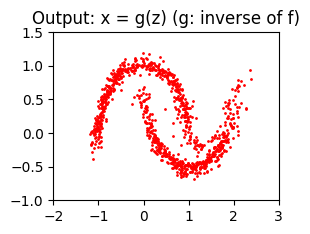

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.120525
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.121201
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.121477
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.121295
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.120840
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.121580
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.121166
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.122275
====> Epoch: 6 Average train loss: -0.1217


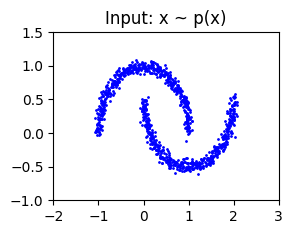

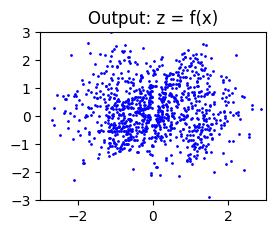

====> Test loss: -0.1245


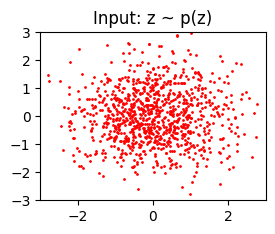

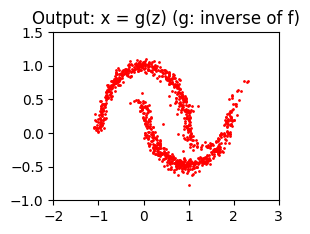

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.121426
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.121543
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.121532
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.121726
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.121275
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.121254
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.122320
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.121657
====> Epoch: 7 Average train loss: -0.1218


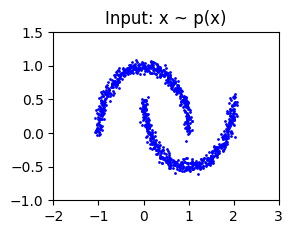

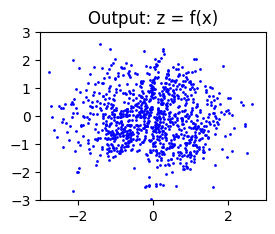

====> Test loss: -0.1248


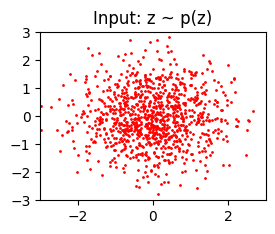

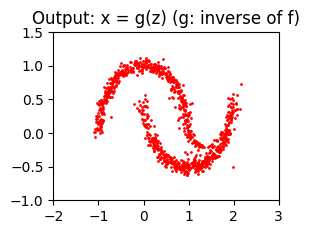

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.122408
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.121929
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.121699
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.121682
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.122505
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.122661
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.121552
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.121627
====> Epoch: 8 Average train loss: -0.1219


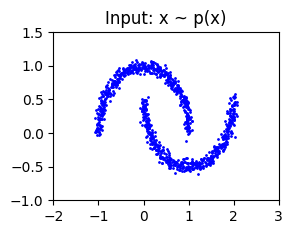

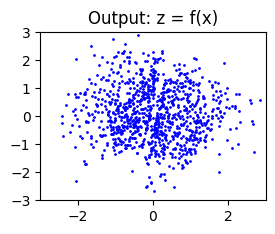

====> Test loss: -0.1248


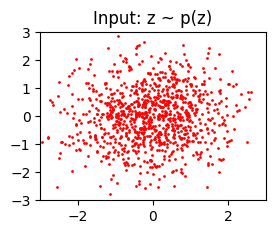

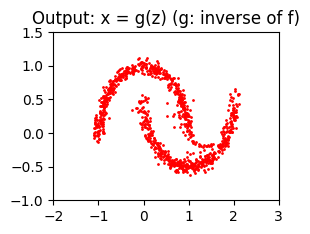

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.122310
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.121601
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.122029
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.121472
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.121611
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.121317
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.122393
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.120855
====> Epoch: 9 Average train loss: -0.1219


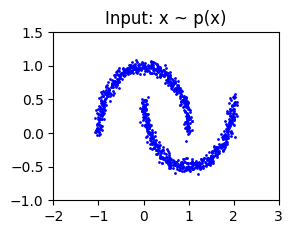

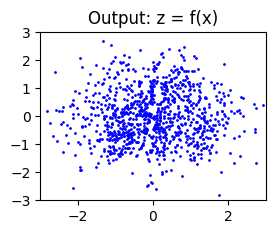

====> Test loss: -0.1249


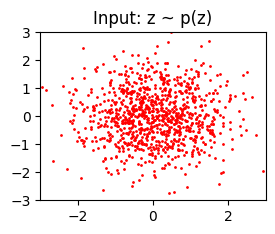

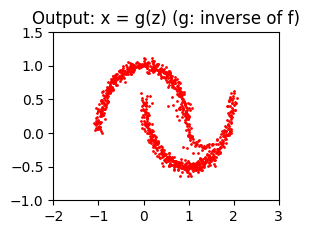

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.122004
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.122284
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.121272
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.121897
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.122607
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.122375
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.122605
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.121471
====> Epoch: 10 Average train loss: -0.1220


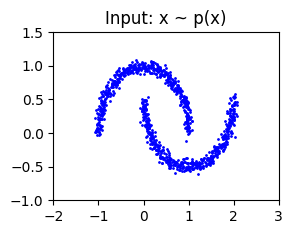

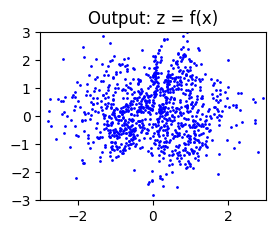

====> Test loss: -0.1244


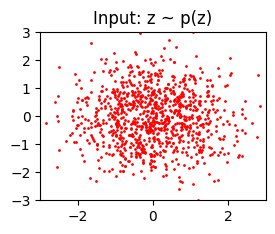

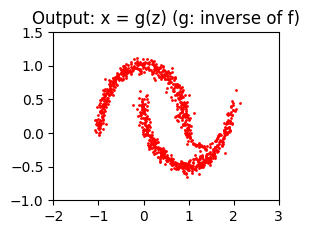

Train Epoch: 11 [0/50000 (0%)]	Loss: -0.122259
Train Epoch: 11 [6400/50000 (13%)]	Loss: -0.122513
Train Epoch: 11 [12800/50000 (26%)]	Loss: -0.122472
Train Epoch: 11 [19200/50000 (38%)]	Loss: -0.121889
Train Epoch: 11 [25600/50000 (51%)]	Loss: -0.121925
Train Epoch: 11 [32000/50000 (64%)]	Loss: -0.122919
Train Epoch: 11 [38400/50000 (77%)]	Loss: -0.122947
Train Epoch: 11 [44800/50000 (90%)]	Loss: -0.122043
====> Epoch: 11 Average train loss: -0.1220


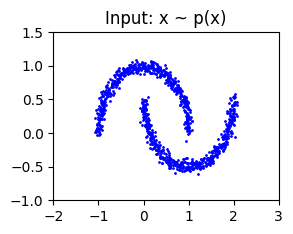

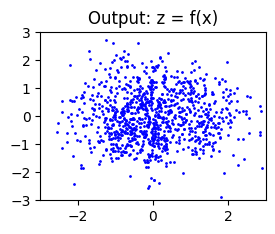

====> Test loss: -0.1249


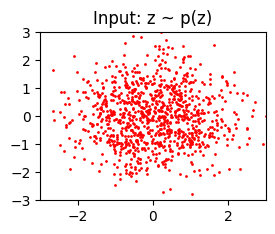

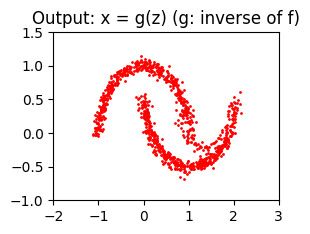

Train Epoch: 12 [0/50000 (0%)]	Loss: -0.120905
Train Epoch: 12 [6400/50000 (13%)]	Loss: -0.121593
Train Epoch: 12 [12800/50000 (26%)]	Loss: -0.121036
Train Epoch: 12 [19200/50000 (38%)]	Loss: -0.122031
Train Epoch: 12 [25600/50000 (51%)]	Loss: -0.122165
Train Epoch: 12 [32000/50000 (64%)]	Loss: -0.121811
Train Epoch: 12 [38400/50000 (77%)]	Loss: -0.121486
Train Epoch: 12 [44800/50000 (90%)]	Loss: -0.121717
====> Epoch: 12 Average train loss: -0.1221


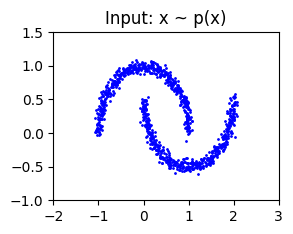

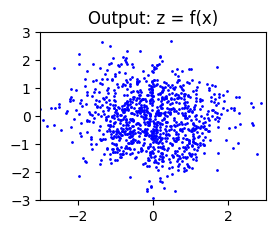

====> Test loss: -0.1250


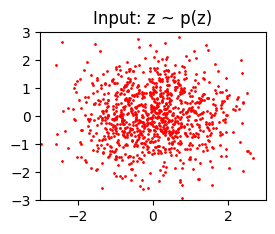

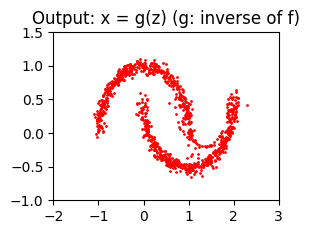

Train Epoch: 13 [0/50000 (0%)]	Loss: -0.121612
Train Epoch: 13 [6400/50000 (13%)]	Loss: -0.122639
Train Epoch: 13 [12800/50000 (26%)]	Loss: -0.121188
Train Epoch: 13 [19200/50000 (38%)]	Loss: -0.122521
Train Epoch: 13 [25600/50000 (51%)]	Loss: -0.121866
Train Epoch: 13 [32000/50000 (64%)]	Loss: -0.122330
Train Epoch: 13 [38400/50000 (77%)]	Loss: -0.122135
Train Epoch: 13 [44800/50000 (90%)]	Loss: -0.122593
====> Epoch: 13 Average train loss: -0.1221


====> Test loss: -0.1249


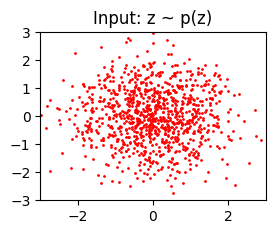

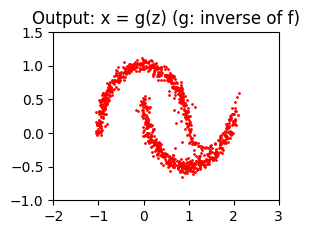

Train Epoch: 14 [0/50000 (0%)]	Loss: -0.122212
Train Epoch: 14 [6400/50000 (13%)]	Loss: -0.121694
Train Epoch: 14 [12800/50000 (26%)]	Loss: -0.120459
Train Epoch: 14 [19200/50000 (38%)]	Loss: -0.121352
Train Epoch: 14 [25600/50000 (51%)]	Loss: -0.122645
Train Epoch: 14 [32000/50000 (64%)]	Loss: -0.122526
Train Epoch: 14 [38400/50000 (77%)]	Loss: -0.122281
Train Epoch: 14 [44800/50000 (90%)]	Loss: -0.122789
====> Epoch: 14 Average train loss: -0.1221


====> Test loss: -0.1250


Train Epoch: 15 [0/50000 (0%)]	Loss: -0.122126
Train Epoch: 15 [6400/50000 (13%)]	Loss: -0.121828
Train Epoch: 15 [12800/50000 (26%)]	Loss: -0.122741
Train Epoch: 15 [19200/50000 (38%)]	Loss: -0.121685
Train Epoch: 15 [25600/50000 (51%)]	Loss: -0.122141
Train Epoch: 15 [32000/50000 (64%)]	Loss: -0.122560
Train Epoch: 15 [38400/50000 (77%)]	Loss: -0.123032
Train Epoch: 15 [44800/50000 (90%)]	Loss: -0.121878
====> Epoch: 15 Average train loss: -0.1221


====> Test loss: -0.1248


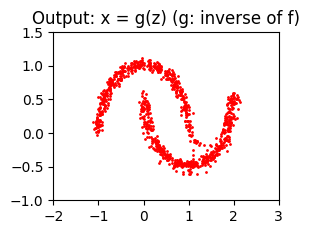

Train Epoch: 16 [0/50000 (0%)]	Loss: -0.122190
Train Epoch: 16 [6400/50000 (13%)]	Loss: -0.121815
Train Epoch: 16 [12800/50000 (26%)]	Loss: -0.122085
Train Epoch: 16 [19200/50000 (38%)]	Loss: -0.121191
Train Epoch: 16 [25600/50000 (51%)]	Loss: -0.122220
Train Epoch: 16 [32000/50000 (64%)]	Loss: -0.122432
Train Epoch: 16 [38400/50000 (77%)]	Loss: -0.121556
Train Epoch: 16 [44800/50000 (90%)]	Loss: -0.120446
====> Epoch: 16 Average train loss: -0.1221


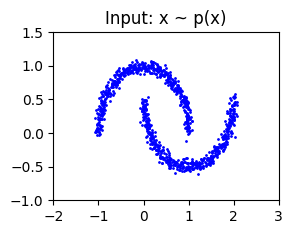

====> Test loss: -0.1252


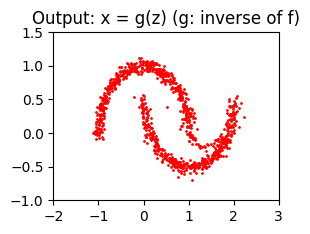

Train Epoch: 17 [0/50000 (0%)]	Loss: -0.122504
Train Epoch: 17 [6400/50000 (13%)]	Loss: -0.122639
Train Epoch: 17 [12800/50000 (26%)]	Loss: -0.122003
Train Epoch: 17 [19200/50000 (38%)]	Loss: -0.122760
Train Epoch: 17 [25600/50000 (51%)]	Loss: -0.122581
Train Epoch: 17 [32000/50000 (64%)]	Loss: -0.121212
Train Epoch: 17 [38400/50000 (77%)]	Loss: -0.121712
Train Epoch: 17 [44800/50000 (90%)]	Loss: -0.121894
====> Epoch: 17 Average train loss: -0.1222


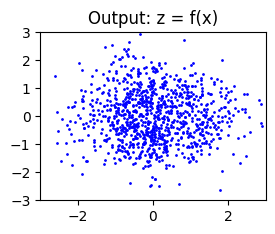

====> Test loss: -0.1251


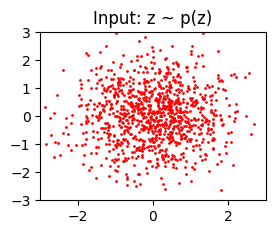

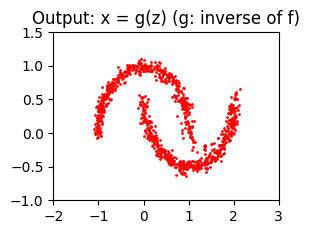

Train Epoch: 18 [0/50000 (0%)]	Loss: -0.122155
Train Epoch: 18 [6400/50000 (13%)]	Loss: -0.122555
Train Epoch: 18 [12800/50000 (26%)]	Loss: -0.121914
Train Epoch: 18 [19200/50000 (38%)]	Loss: -0.123179
Train Epoch: 18 [25600/50000 (51%)]	Loss: -0.121265
Train Epoch: 18 [32000/50000 (64%)]	Loss: -0.122254
Train Epoch: 18 [38400/50000 (77%)]	Loss: -0.121414
Train Epoch: 18 [44800/50000 (90%)]	Loss: -0.122842
====> Epoch: 18 Average train loss: -0.1222


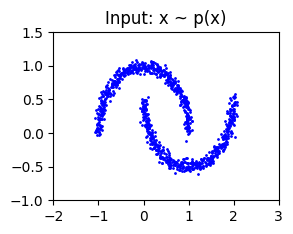

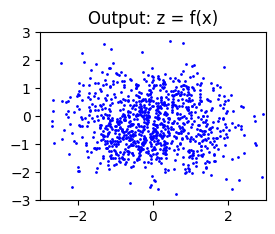

====> Test loss: -0.1248


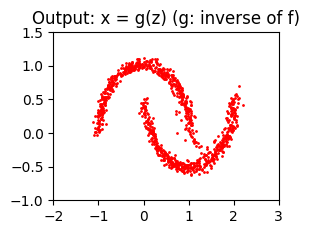

Train Epoch: 19 [0/50000 (0%)]	Loss: -0.121410
Train Epoch: 19 [6400/50000 (13%)]	Loss: -0.120984
Train Epoch: 19 [12800/50000 (26%)]	Loss: -0.121746
Train Epoch: 19 [19200/50000 (38%)]	Loss: -0.122091
Train Epoch: 19 [25600/50000 (51%)]	Loss: -0.121267
Train Epoch: 19 [32000/50000 (64%)]	Loss: -0.121668
Train Epoch: 19 [38400/50000 (77%)]	Loss: -0.121396
Train Epoch: 19 [44800/50000 (90%)]	Loss: -0.122952
====> Epoch: 19 Average train loss: -0.1222


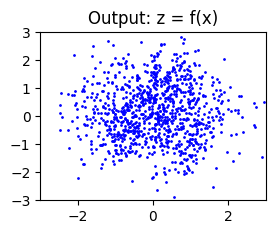

====> Test loss: -0.1250


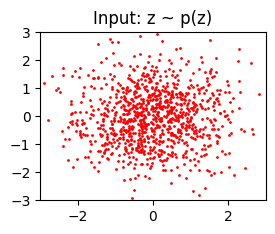

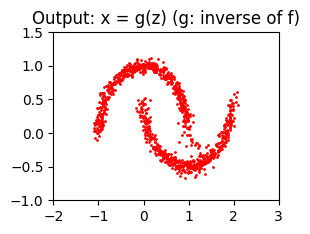

Train Epoch: 20 [0/50000 (0%)]	Loss: -0.121817
Train Epoch: 20 [6400/50000 (13%)]	Loss: -0.121687
Train Epoch: 20 [12800/50000 (26%)]	Loss: -0.122443
Train Epoch: 20 [19200/50000 (38%)]	Loss: -0.121775
Train Epoch: 20 [25600/50000 (51%)]	Loss: -0.121990
Train Epoch: 20 [32000/50000 (64%)]	Loss: -0.122005
Train Epoch: 20 [38400/50000 (77%)]	Loss: -0.122573
Train Epoch: 20 [44800/50000 (90%)]	Loss: -0.122255
====> Epoch: 20 Average train loss: -0.1222


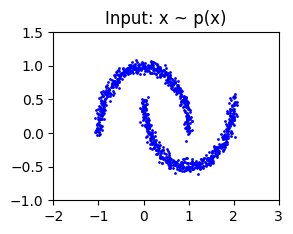

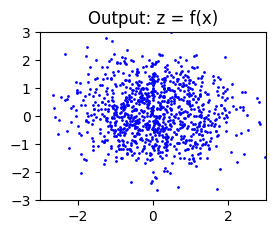

====> Test loss: -0.1253


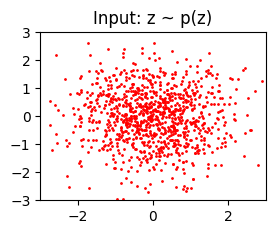

'200.52s'

<Figure size 640x480 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    if epoch>5:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

>* Normalizing flows employ a series of reversible transformations to capture the intricacies of the data distribution. Unfortunately, these transformations possess limited expressiveness, posing a significant challenge in accurately modeling a highly multimodal distribution consisting of numerous separate clusters. Though increasing the flow's depth or complexity may somewhat alleviate this, it also increases computational complexity and training difficulty.
>
>* Moreover, normalizing flows may encounter difficulty in learning appropriate transformations to accurately model and segregate multiple clusters, particularly when the clusters are distant or possess intricate shapes. Consequently, the poorly-modeled cluster regions degrade the quality of generated samples.
>
>* Further, normalizing flows may face difficulties in separating different clusters, resulting in generated samples that mix the features of different clusters, contradicting the actual data distribution. As a consequence, the generated samples may not accurately represent any of the authentic clusters present in the data.

## Denoising Diffusion Model

Recently Diffusion Models received a lot of attention. __Diffusion Models Beat GANs on Image Synthesis__ *(Dhariwal,Nichol)* : [arXiv:2105.05233](https://arxiv.org/pdf/2105.05233.pdf) shows significant improvement on image generation with a model claimed to be easier to train than GANs.


It is the key of the image generating process behind Latent Diffusion models such as Dall.e, Imagen or StableDiffusion. 

We are going to implement a model inspired by the paper
__Denoising Diffusion Probabilistic Models__  *(Ho et al.)*: [arXiv:2006.11239](https://arxiv.org/pdf/2006.11239.pdf) 


 Denoising diffusion probabilistic model  introduce noise into data and gradually learn to reverse this process for generating new samples. It involves two Markov chains, one that forwards data to noise, and another that reverses this process by converting the noise back to data. The forward chain is usually designed to transform any data distribution into a simpler prior distribution, such as a standard Gaussian distribution, while the reverse Markov chain is parametrized by a neural network and learns to reverse this process. To generate new data points, we first sample a random vector from the prior distribution, then applies ancestral sampling through the reverse Markov chain.


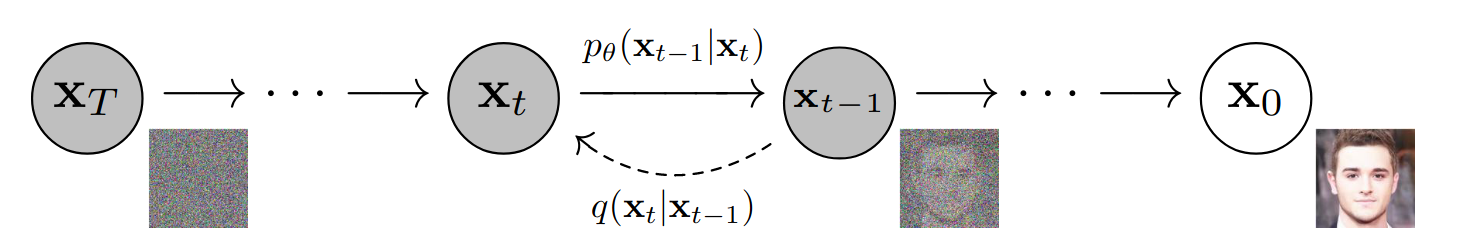

$q$ and $p_{\theta}$ being the respective kernels of the two chains. 


#### Forward Pass ####

For our purpose we are going to use a Gaussian Noise. The forward Kernel will have the following shape : 

$$q(x_t| x_{t-1}) = \mathcal{N}(x_t;\sqrt{1- \beta_t} x_{t-1},\beta_t I )$$

with $\mathcal{N}(x;\mu,\sigma I )$ a conditional gaussian :
$$ y \sim \mathcal{N}(x;\mu,\sigma I ) \equiv y|x \sim  \mathcal{N}(\mu,\sigma I )$$

**Q20: What does $\beta_t$ represent in the formula ?**

> $\beta_t$ represents the diffusion coefficient at time t. It controls the amount of noise added to the data at each step of the forward pass.



In our example the sequence $\beta_t$ will be chosen linearly wrt $t$. 

In [ ]:
def linear_beta_schedule(timesteps=1000,start=1e-4, end=1e-2): 
    """ Return the values of beta for all timesteps"""
    return torch.linspace(start, end, timesteps)

Following the paper, we introduce $\alpha_t := 1-\beta_t$ and $\overline{\alpha_t} = \prod_{t=1}^{T} \alpha_t$ we can sample forward directly at timestep t from the original image : 
$$q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t=1}^{T}q(\mathbf{x}_t|\mathbf{x}_{t-1})$$
$$ q(\mathbf{x}_t| \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\overline{\alpha_t}} \mathbf{x}_0, (1-\overline{\alpha_t})I)$$

**Q21:  Implement the forward pass using $\overline{\alpha_t}$ (Hint : you may need to precalculate the $\overline{\alpha_t}$ from $\beta_t$)**

In [ ]:
def forward_close_form(x_0, t):
    """Take an input image, a number of steps t, and a function that returns the beta schedule, sample the forward markov chain until the Tth step."""
    noise = torch.randn_like(x_0)
    betas = linear_beta_schedule(t)
    alpha_bar = torch.prod(1 - betas)
    x_t = torch.sqrt(alpha_bar)*x_0+torch.sqrt(1-alpha_bar)*noise
    return x_t, noise

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs,drop_last=True)

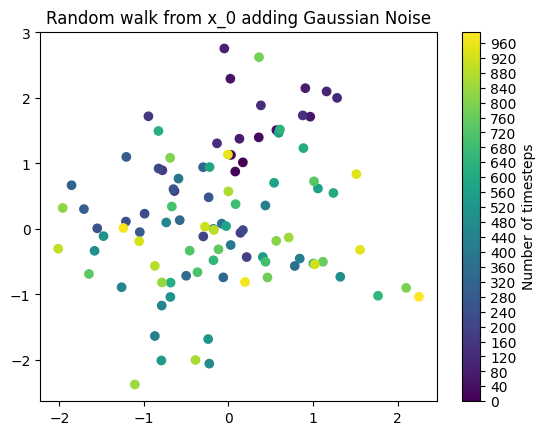

In [ ]:
# Simulate forward diffusion
from matplotlib import ticker

T = 1000
image = next(iter(train_loader))[0]
plt.scatter
num_images = 100
images = np.zeros((num_images,2))
images[0]=image
stepsize = int(T/num_images)
color = np.arange(num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    image, _ = forward_close_form(image, t.item())
    images[int(idx/stepsize)] = image

plt.scatter(images[:,0],images[:,1],c=color*stepsize,)
plt.title("Random walk from x_0 adding Gaussian Noise")
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=30)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label("Number of timesteps")
plt.show()

In [ ]:
# Effect on the distribution
torch_test_data = torch.Tensor(test_data)
def apply_on_dataset(dataset,t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        point_t,_ = forward_close_form(point, t)
        dataset_t[i] = point_t
    return dataset_t

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].scatter(torch_test_data[:,0],torch_test_data[:,1])
for i in range(1,5):
    t = torch.Tensor([i*50]).type(torch.int64)
    dataset_t = apply_on_dataset(torch_test_data,t.item())
    axes[i].scatter(dataset_t[:,0],dataset_t[:,1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the forward pass on the distribution")
plt.show()

#### Backward Process

Hypothetically, We would like  to train the reverse kernel $p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$, with parameters $\theta$ parametrized by a neural network 

$$
p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)
$$

with $p(\mathbf{x}_T)$ a Gaussian prior, $p(\mathbf{x}_T) \sim \mathcal{N}(0,I)$ . We would use $p(\mathbf{x}_T)$ to sample new data points for generation.

#### Variational Lower Bound 

In the paper, they used the knowledge of the forward pass and design a  Gaussian  reverse kernel

$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$

with $\mu_{\theta}$ and $\Sigma_{\theta}$  parametrized by a neural network

We can write the previous forward kernel
$$
\begin{aligned}
q\left(\mathbf{x}_t \mid \mathbf{x}_0\right) & =\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right) \\
& =\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\epsilon \sqrt{1-\bar{\alpha}_t}
\end{aligned}
$$
with $ \epsilon \sim \mathcal{N}(0, \mathbf{I})$ 

The natural loss would be to optimize under the variational lower bound $L_t$ such that : 
$$
\begin{aligned}
L_{\mathrm{vlb}} & :=L_0+L_1+\ldots+L_{T-1}+L_T \\
L_0 & :=-\log p_\theta\left(x_0 \mid x_1\right) \\
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
L_T & :=D_{K L}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)
\end{aligned}
$$

You can show ( and you are welcome to do so) that an alternative loss can be used that only take one parametrized estimator $\epsilon_{\theta}$ 
$$
L_{\text {simple }}(\theta):=\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}}\left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\right]
$$

**Q.23 Implement the Simplified loss given a model $\epsilon_{\theta}$**

In [ ]:
def get_loss(model, x_0, t):
    """Return the Loss.

    Args:
        model (nn.Module): epsilon_theta
        x_0 (torch.Tensor): Original Image
        t (torch.Tensor): Integer describing time
    """
    x_noisy, noise = forward_close_form(x_0, t, device)
    #
    # TO COMPLETE
    #
    return 0

From the paper [arxiv:1706.03762](https://arxiv.org/pdf/1706.03762.pdf) we can use Sinusoidal Position Embeddings to help the model represent time position  of the noised input $(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon})$ on the reverse markov chain given $t$.

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

**Q.24 Implement and train $\epsilon_{\theta}(\mathbf{x},t)$ that take as entry a transformed vector $\mathbf{x}$ and  $t$ a number of time $\mathbf{x}$ passed through the forward process  and return  a direct estimate of  the noise $\epsilon$**

In [ ]:
class Simple_Reverse_Kernel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 2)
        self.time_embedding = SinusoidalPositionEmbeddings(32)
        self.time_mlp = torch.nn.Linear(32,2)
        self.merge_mlp = torch.nn.Linear(4,2)
    
    def forward(self, x, t):
        x = F.relu(self.fc1(x))
        t = F.relu(self.time_mlp(self.time_embedding(t).reshape(-1,32)))
        return self.merge_mlp(torch.cat((x,t),dim=1))  

#### Training

**Q.25 Test this  training procedure for multiple architectures and analyse your results.**

In [ ]:
def train(model,optimizer,n_epochs, data):
    error = []
    for epoch in range(n_epochs):
      for step, batch in enumerate(data):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        loss = get_loss(model, batch, t)
        loss.backward()
        optimizer.step()
      print(f"Epoch {epoch} | Loss: {loss.item()} ")
      error.append(loss.item())
    return error  

In [ ]:
model = Simple_Reverse_Kernel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
error = train(model,optimizer,100,train_loader)

> (Write your answer here)

#### Reconstruction of outputs

Given the noise obtained by the model $\boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)$, you can sample $\mu_{\theta}(\mathbf{x}_t,t)$ in order to get a denoised sample point.
$$
\mu_{\theta}(\mathbf{x}_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)
$$ 

**Q.26 Build the sampling function that allows you from inputs $\mathbf{x}_t$ and $t$ to obtain $\mu_{\theta}(\mathbf{x}_t,t)$**

In [ ]:
def sampling_model(x, t):
    with torch.no_grad():
        betas = linear_beta_schedule(timesteps=t.item())
        beta_t = betas[-1].item()
        alpha_bar = torch.prod(1 - betas).item()
        error = model(x, torch.tensor([t]))
        mu_theta = 1 / np.sqrt(alpha_bar) * (x - beta_t/np.sqrt(1 - alpha_bar) * error)
    return mu_theta

In [ ]:
# Effect on the distribution
noise_dataset = torch.empty(1000,2).uniform_()
def backward_on_dataset(dataset,t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        noise_t= model(point.reshape(-1,2), t.unsqueeze(-1).float())
        point_t = sampling_model(point.reshape(-1,2),t)
        dataset_t[i] = point_t
    return dataset_t

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].scatter(noise_dataset[:,0],noise_dataset[:,1])
for i in range(1,5):
    t = torch.Tensor([i*50]).long()
    dataset_t = backward_on_dataset(noise_dataset,t)
    axes[i].scatter(dataset_t.detach().numpy()[:,0],dataset_t.detach().numpy()[:,1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the backward pass on a test dataset")
plt.show()

Survey on Diffusion Models : https://arxiv.org/pdf/2209.00796.pdf

### Conclusion

**Q.27: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Normalizing flows and Denoising Models ?**

* While GANs are useful for generating images, they appear to have limited creative potential when it comes to this particular type of data. The first graph indicates that the produced data closely resembles the original distribution. It is clear that this model can only reproduce data for the $P_D$ distribution. Therefore, if the $P_D$ data is significantly limited compared to the real $P_\theta$ distribution, the results will be mediocre.

* According to our experiments, VAE algorithms are hard to caliber in order to make the results is signigicantly accurate. Furthermore, the complexity will increase with the growing complexity of the distribution.

* While normalizing flows seem to offer superior data reconstruction, their computational cost is considerably higher, taking several minutes as opposed to just a few seconds.